# Website classification

In [1]:
import pandas as pd

## Problem definition

For the purposes of this report, this team is attempting to determine an ideal model/algorithm that will allow users to classify any website based on the contents of the website.

We will start off by loading the data:

In [2]:
data = pd.read_csv("website_classification.csv")

In [3]:
data.shape

(1408, 4)

In [4]:
data.head()

,Unnamed: 0,website_url,cleaned_website_text,Category
0,0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel
1,1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel
2,2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel
3,3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel
4,4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel


#### This is what our raw data looks like. 1408 website_url's with their corresponding website text and category. The provided data has already been cleaned, filtered, and tokenized. This means that all tokens have been lower cased, all conjunctions, periods, and other delimeters have been removed.

In [5]:
data = data.drop(columns=['Unnamed: 0'])

#### We drop the Unnamed coloumn and add a 'Category ID' value to denote the numerical representation of our labels. 

In [6]:
data['Category_ID'] = data.Category.factorize()[0]

In [7]:
data.head()

,website_url,cleaned_website_text,Category,Category_ID
0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel,0
1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel,0
2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel,0
3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel,0
4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel,0


In [8]:
data.cleaned_website_text[0]

'official site good hotel accommodation big saving hotel destination worldwide browse hotel review find guarantee good price hotel budget lodging accommodation hotel hotels special offer package special weekend break city break deal budget cheap discount saving select language find deal hotel home try search connect traveller india travel talk community recommend destination flamborough boreland colvend catfield harberton warleggan inspiration trip spot winter wildlife beautiful snowy island bye bye work want spontechnaity tech drive travel vital value maximise travel homes guest love browse property type hotels apartments resorts villa cabins cottage glamping serviced apartment holiday home guest house hostels motels ryokans riads holiday park homestays campsites country house farm stay boats luxury tent self catering accommodation tiny house chapel saint leonards wuqing wuchang saint eval great rowsley instow verified review real guest work start booking follow trip finally review sk

#### This table serves as our key to convert our numerical representations of the labels with the verbose ones

In [9]:
key = pd.DataFrame(data.Category.unique())
key

,0
0,Travel
1,Social Networking and Messaging
2,News
3,Streaming Services
4,Sports
5,Photography
6,Law and Government
7,Health and Fitness
8,Games
9,E-Commerce


For this experiment, we want to focus on how we can use the contents of the website to classify a website. As such, we have assigned the X and Y values as:

In [10]:
key
X = data['cleaned_website_text'] 
y = data['Category']

To ensure proper training/test seperation of the data, we are setting aside 25% of the available data to test the final model.

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)

# Data Analysis

Before starting the experiments, we wanted to get a better understanding of what the data looks like and the overall distribution of labels. We do a quick visualization of the data to get an understanding of the distributions of categories. We can see that there is roughly a 20% discrepancy of inputs between Social Networking and Messaging as there is Education and Business/Corporate. Websites categorized as Forums and Adult are very infrequent in this dataset. This well help us analyze our model results later.


<Axes: xlabel='count', ylabel='Category'>

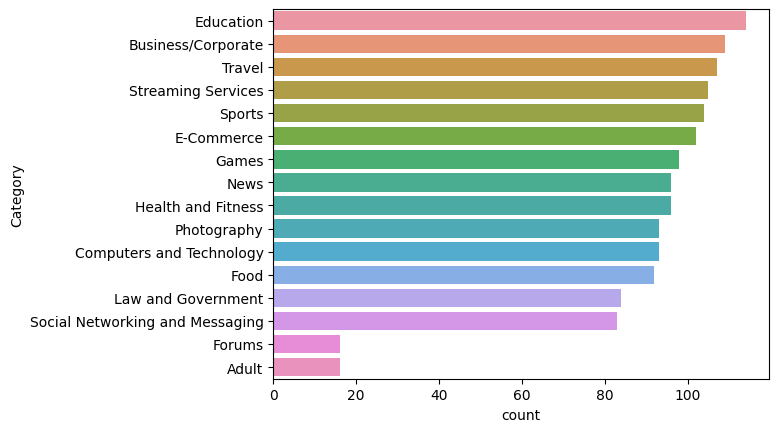

In [12]:
import seaborn as sns
sns.countplot(y=data['Category'],order=data['Category'].value_counts().index[:16])

In [13]:
pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
from wordcloud import WordCloud,STOPWORDS

In [15]:
def show_word_cloud(category):
    plt.figure(figsize=(40,25))
    subset = data[data['Category']==category]
    text = subset.cleaned_website_text.values
    cloud1=WordCloud(stopwords=STOPWORDS,background_color='white',colormap="Dark2",collocations=False,width=2500,height=1800).generate(" ".join(text))
    plt.subplot(4,4,1)
    plt.axis('off')
    plt.title(category ,fontsize=40)
    plt.imshow(cloud1)

#### One of our preliminary theories is that the frequency of certain words correlate to the classification of the website. This function helps us get a good visual representation of the words that are most common to each category. 

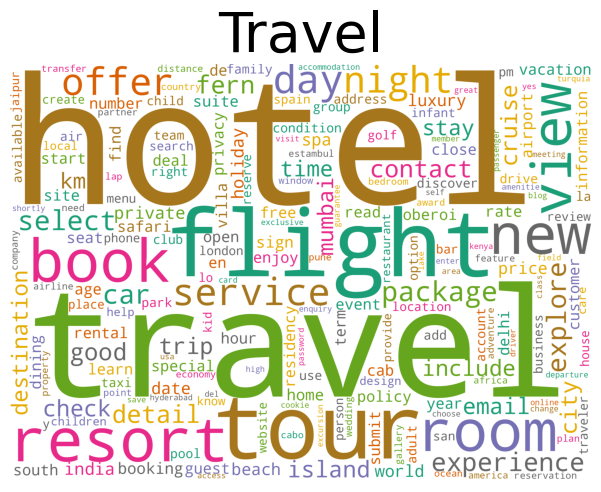

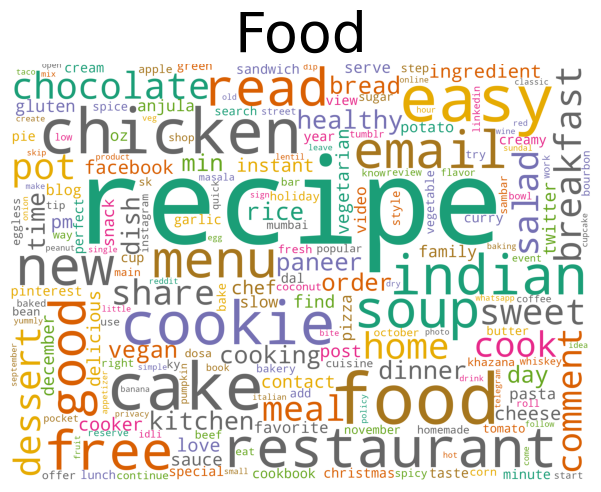

In [16]:
import matplotlib.pyplot as plt 
show_word_cloud("Travel")
show_word_cloud("Food")

# Base model

Prior to training our models, we wanted to create a base model that will serve as a benchmark for our models. We implement a simple baseline model that takes the most common Category type and applies it as the prediction for our test values. It does not do so well but is the most elementary model we can form.

In [17]:
import numpy as np 

def base_model(input):
    return "Education"

Y_train_baseline_pred = X_train.apply(base_model)

print("Training accuracy of base model : %.3f" % (np.sum(y_train == Y_train_baseline_pred)/len(y_train)))

Training accuracy of base model : 0.077


# Experimentation

To begin, we must translate the tokens into an alternative representation that we can feed into our models. There are two approaches we decided to attempt: word embeddings and Bag of Words. To begin with, let's start the analysis by using word embeddings.

## Word Embeddings

A common feature engineering technique used for natural language is to condense the alphanumerically represented sentences into one-hot representations. 

This will turn our cleaned text into an array that will be easier processed by our machine learning algorithm.

The algorithm that is being used here is the TF-IDF algorithm (term-frequency inverse document frequency). This algorithm repurposes each individual sentence as an array of numbers that represent how frequent each term (word) is found in the context of that particular document as well as by that particular corpus of documents.

For example - if the word "recipe" was found very commonly in the "Food" category it would have a higher representation. If the word "recipe" was also found very commonly in other website texts that were also categorized as "Food", this would elevate the represetentation of that word even more.


https://tfidf.com/
https://towardsdatascience.com/tf-term-frequency-idf-inverse-document-frequency-from-scratch-in-python-6c2b61b78558

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

features = tfidf.fit_transform(data.cleaned_website_text).toarray()

In [19]:
features[0]

array([0.        , 0.        , 0.        , ..., 0.05559256, 0.04305935,
       0.        ])

The variable "features" now stores the tf-idf representations of all the collected website text. After transforming all the data, let's attempt to split the data where 25% is reserved for testing.

In [20]:
labels = data.Category_ID
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               data.index, test_size=0.25, 
                                                               random_state=1)

We'll create a list of models that we want to use to classify our data.

In [21]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    MultinomialNB(),
    GaussianNB(),
    LinearSVC(),
]


#### We start off by doing a cross_validation analysis by using the cross_val_score in sklearn 

We split up the raw train data into train and test splits and fitting them with various folds into our four basic models we chose for text classification. These models were chosen based on literature reviews done on similar datasets and models that were most frequently tested. 

In the cell below we run the tests to determine which model shows the most promise. Cross_val_scores takes our model of choice, features and number of folds and spits out the accuracy that model has. 

In [22]:
labels = data.Category_ID
cross_validations = 5

run = []

for model in models:
    accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cross_validations)
    for fold, accuracy in enumerate(accuracies):
        run.append((model, fold, accuracy))
    
CV = pd.DataFrame(run, columns=['Model', 'Folds', 'Accuracy'])
CV

,Model,Folds,Accuracy
0,"RandomForestClassifier(max_depth=5, random_sta...",0,0.721698
1,"RandomForestClassifier(max_depth=5, random_sta...",1,0.763033
2,"RandomForestClassifier(max_depth=5, random_sta...",2,0.763033
3,"RandomForestClassifier(max_depth=5, random_sta...",3,0.744076
4,"RandomForestClassifier(max_depth=5, random_sta...",4,0.763033
5,MultinomialNB(),0,0.867925
6,MultinomialNB(),1,0.886256
7,MultinomialNB(),2,0.857820
8,MultinomialNB(),3,0.857820
9,MultinomialNB(),4,0.900474


#### We can see that the LinearSVC model has the highest accuracy across the average of cross validation folds so we will use that as our base model.

In [30]:
import tensorflow as tf
from sklearn import metrics

tf.keras.backend.clear_session()
tf.random.set_seed(0)

model = LinearSVC()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
print(metrics.accuracy_score(y_test, predictions))

0.9403409090909091


In [25]:
predictions = model.predict(X_test)

Text(0.5, 80.7222222222222, 'Predicted')

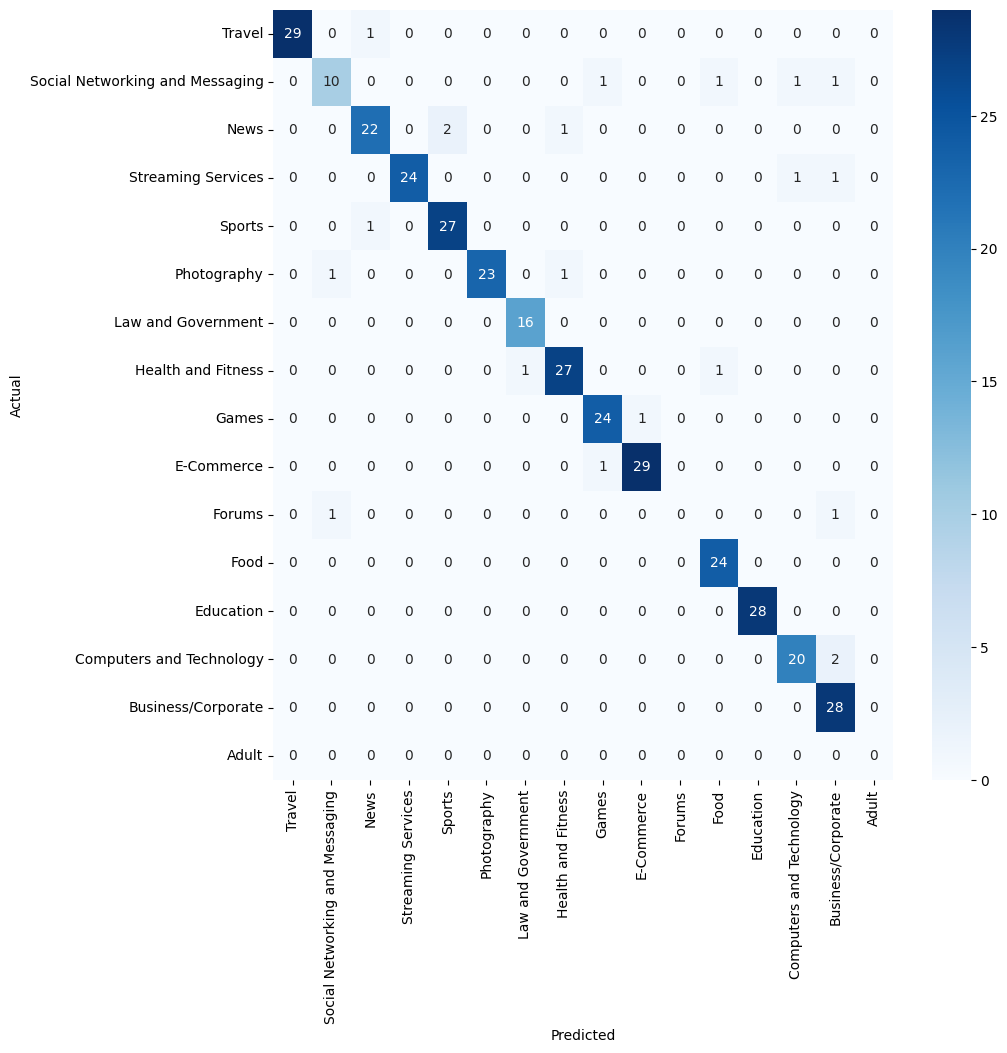

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, predictions,labels=[i for i in range(len(key))])

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=key[0].values, 
            yticklabels=key[0].values)

plt.ylabel('Actual')
plt.xlabel('Predicted')

In [31]:
print(metrics.classification_report(y_test,predictions,labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],target_names= data['Category'].unique()))

                                 precision    recall  f1-score   support

                         Travel       1.00      0.97      0.98        30
Social Networking and Messaging       0.83      0.71      0.77        14
                           News       0.92      0.88      0.90        25
             Streaming Services       1.00      0.92      0.96        26
                         Sports       0.93      0.96      0.95        28
                    Photography       1.00      0.92      0.96        25
             Law and Government       0.94      1.00      0.97        16
             Health and Fitness       0.93      0.93      0.93        29
                          Games       0.92      0.96      0.94        25
                     E-Commerce       0.97      0.97      0.97        30
                         Forums       0.00      0.00      0.00         2
                           Food       0.92      1.00      0.96        24
                      Education       1.00      1.

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1

# Bag of words

In addition to the word embeddings representation, we also tried our models against a bag of words representation. The bag of words representation of text describes the occurrence of words within a document or in our case, the website texts. It involves two things, a vocabulary of known words and a measure of the presence of known words. Information about the order or structure of words in the document is discarded. 

We start off by using a vectorizer , which has been trained using the training data, and transform the inputs into bag of words representation. The count vectorizer converts the text input to a matrix of token counts.

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)

vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(X_train)

X_train_bow = vectorizer.transform(X_train)
X_test_bow  = vectorizer.transform(X_test)

In [33]:
(X_train_bow[0])

<1x50763 sparse matrix of type '<class 'numpy.int64'>'
	with 295 stored elements in Compressed Sparse Row format>

In order to ensure consistency, the same types of models were used for classifying bag of words representations of the website text data:

In [34]:
cross_validations = 5

run = []

for model in models:
    accuracies = cross_val_score(model, X_train_bow.toarray(), y_train, scoring='accuracy', cv=cross_validations)
    for fold, accuracy in enumerate(accuracies):
        run.append((model, fold, accuracy))
    
CV = pd.DataFrame(run, columns=['Model', 'Folds', 'Accuracy'])
CV

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,Model,Folds,Accuracy
0,"RandomForestClassifier(max_depth=5, random_sta...",0,0.702830
1,"RandomForestClassifier(max_depth=5, random_sta...",1,0.691943
2,"RandomForestClassifier(max_depth=5, random_sta...",2,0.663507
3,"RandomForestClassifier(max_depth=5, random_sta...",3,0.663507
4,"RandomForestClassifier(max_depth=5, random_sta...",4,0.701422
5,MultinomialNB(),0,0.896226
6,MultinomialNB(),1,0.890995
7,MultinomialNB(),2,0.909953
8,MultinomialNB(),3,0.843602
9,MultinomialNB(),4,0.919431


The accuracy produced by these models is lower than the word embeddings approach.


# Conclusion

To attempt this experiment, two different represenations of the text data were considered. The word embeddings approach yielded a higher accuracy on avergage. Thus additional experiments and the final model was constructed using the word embeddings approach. 

The final model rendered a test accuracy of 93.75%. When compared to the baseline model, all model performed well. When looking at the break down of predictions vs actual labels, we found that the underpresentated website categories were difficult to predict for this model. 

# NeurIPs Checklist

To close out our experiment, we wanted to include an overview of some of the topics discussed in the NeurIPS paper checklist. We wanted to offer up and discuss any possible concerns that could arise from our research.


1. For all authors...

(a) Do the main claims made in the abstract and introduction accurately reflect the paper's contributions and scope?

*Yes*

(b) Have you read the ethics review guidelines and ensured that your paper conforms to them?

*Yes*

(c) Did you discuss any potential negative societal impacts of your work?

*The nature of this study suggests that there would be very limited negative impact.*


(d) Did you describe the limitations of your work?


*Due to the nature of how this data was retrieved, it may not be possible to gather the same/similar data if this experiment is to be repeated. The internet is ever evolving and since the majority of this data set was retrieved by scrapping, the resulting data set will likely contain a different distributions of website categories. 

Additionally, these models were trained by using data from predominantly english language websites, as such the resulting model will have a difficult time classifying information in languages that it has not seen before.*


2. If you are including theoretical results...


N/A


3. If you ran experiments...

(a) Did you include the code, data, and instructions needed to reproduce the main experimental results (either in the supplemental material or as a URL)?


*Yes*

(b) Did you specify all the training details (e.g., data splits, hyperparameters, how they were chosen)?

*Yes*

(c) Did you report error bars (e.g., with respect to the random seed after running experiments multiple times)?

*No*

(d) Did you include the amount of compute and the type of resources used (e.g., type of GPUs, internal cluster, or cloud provider)?

*No*

(a) If your work uses existing assets, did you cite the creators?

*N/A*

(b) Did you mention the license of the assets?

*N/A*


(c) Did you include any new assets either in the supplemental material or as a URL?

*N/A*

(d) Did you discuss whether and how consent was obtained from people whose data you're using/curating?

*No*

(e) Did you discuss whether the data you are using/curating contains personally identifiable information or offensive content?

*No*

(a) Did you include the full text of instructions given to participants and screenshots, if applicable?

*Yes*

(b) Did you describe any potential participant risks, with links to Institutional Review Board (IRB) approvals, if applicable?

*N/A*

(c) Did you include the estimated hourly wage paid to participants and the total amount spent on participant compensation?

*N/A*